<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#EDA-2" data-toc-modified-id="EDA-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA 2</a></span><ul class="toc-item"><li><span><a href="#Contingencias-Ozono-CDMX-vs-Guadalajara" data-toc-modified-id="Contingencias-Ozono-CDMX-vs-Guadalajara-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Contingencias Ozono CDMX vs Guadalajara</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.plotly as py
import plotly.graph_objs as go
import mplleaflet

pd.options.mode.chained_assignment = None
pd.set_option('max_columns', 100)

%matplotlib inline

# Init data

## Estaciones

In [14]:
estaciones = pd.read_csv('/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [5]:
mediciones = pd.read_csv('/data_mediciones_todas_estaciones.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [3]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [4]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

# EDA 2

In [6]:
mediciones.groupby('parametro').valororig.describe(percentiles=[0.25, 0.9, 0.98, 0.99])

,count,mean,std,min,25%,50%,90%,98%,99%,max
parametro,,,,,,,,,,
CO,469040.0,131.256801,52200.737311,-630.230,0.400000,0.629000,2.000,5.713844,7.837122,3.572734e+07
NO2,468017.0,0.186630,1.778766,-6.693,0.007113,0.013800,0.036,0.066000,7.633736,5.062300e+01
O3,535060.0,0.002173,6.968772,-809.170,0.011910,0.025058,0.061,0.089000,0.106000,2.579400e+02
PM10,450187.0,71.679258,153.992616,-278.320,26.000000,42.000000,101.000,970.000000,973.090000,2.033300e+04
PM2.5,345758.0,50.087718,168.708588,-9999.000,11.575324,19.127033,46.000,906.520019,970.880000,1.741900e+03
SO2,467808.0,0.052523,0.828627,-10.918,0.001200,0.003000,0.013,0.241387,1.943223,3.072526e+02
TMP,504130.0,29.230095,87.786693,-99.000,14.330000,18.900000,28.500,588.004200,604.660000,3.564400e+03


In [7]:
aux = mediciones.groupby(['city']).agg({'valororig':'count', 'estacionesid':'nunique'}).reset_index()
aux.sort_values('valororig', ascending=False, inplace=True)
aux['pc_acumulado'] = (aux.valororig/aux.valororig.sum()).cumsum()
aux = aux[aux.pc_acumulado<0.8].set_index('city')
aux['mediciones_estacion'] = aux.valororig/aux.estacionesid
aux.head()

,valororig,estacionesid,pc_acumulado,mediciones_estacion
city,,,,
Valle de México,856500,32,0.265689,26765.625000
Guadalajara,298592,10,0.358313,29859.200000
Toluca,228341,6,0.429145,38056.833333
Monterrey,109728,11,0.463183,9975.272727
Salamanca,108140,3,0.496728,36046.666667


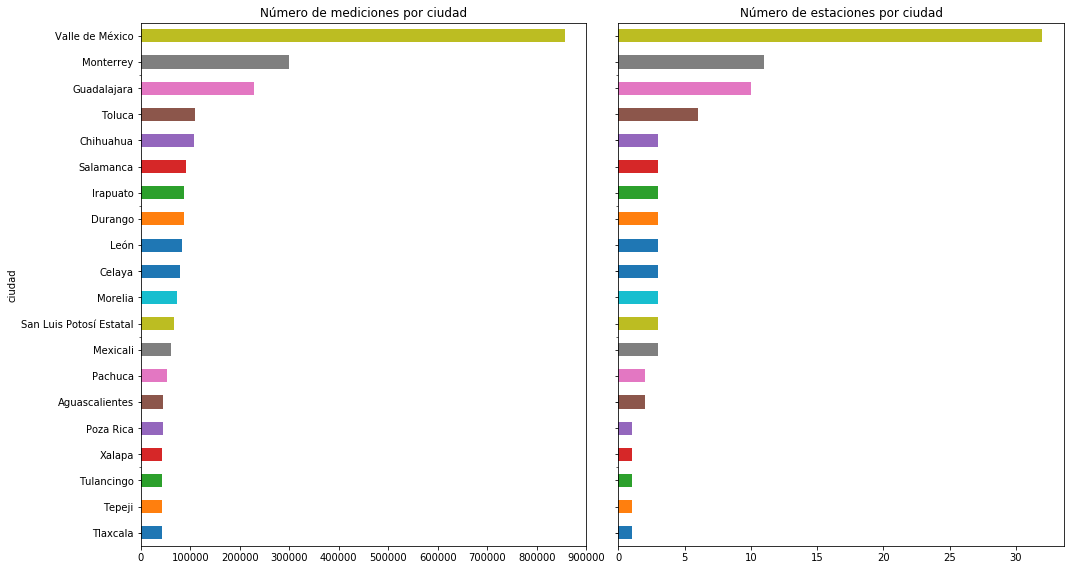

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
aux.index.name = 'ciudad'
aux_ax = ax.flatten()

aux.sort_values('valororig').valororig.plot.barh(title='Número de mediciones por ciudad', ax=aux_ax[0])
aux.sort_values('estacionesid').estacionesid.plot.barh(title='Número de estaciones por ciudad', ax=aux_ax[1])

plt.tight_layout(True)

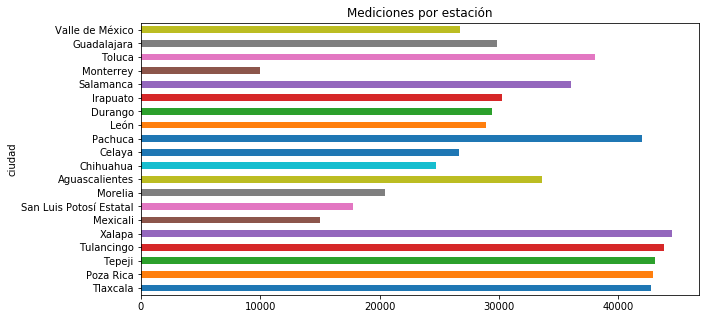

In [9]:
aux.sort_values('valororig').mediciones_estacion.plot.barh(title='Mediciones por estación', figsize=(10, 5))

In [10]:
# Sacado de acá (no son los datos más actualizados, se usan como referencia)
# http://dgeiawf.semarnat.gob.mx:8080/ibi_apps/WFServlet?IBIF_ex=D3_R_AIRE01_04&IBIC_user=dgeia_mce&IBIC_pass=dgeia_mce
# limites_nom = {'CO':50, 'NO2':2, 'O3':0.6, 'SO2':1, 'PM10':600, 'PM2.5':600}

# Estos límites son usando el percentil ~98%
limites_98 = {'CO':10, 'NO2':1, 'O3':0.2, 'SO2':0.3, 'PM10':600, 'PM2.5':600}

def filtra_mediciones(df_mediciones, parametro):
    # Las mediciones no pueden ser negativas, también vamos a ignorar ceros, menos en temperatura
    if parametro!='TMP':
        filtered_data = df_mediciones[(df_mediciones.valororig>0) &
                                      (df_mediciones.valororig<limites_98[parametro])]
    else:
        filtered_data = df_mediciones[df_mediciones.valororig.between(-20, 50)]
        
    return filtered_data

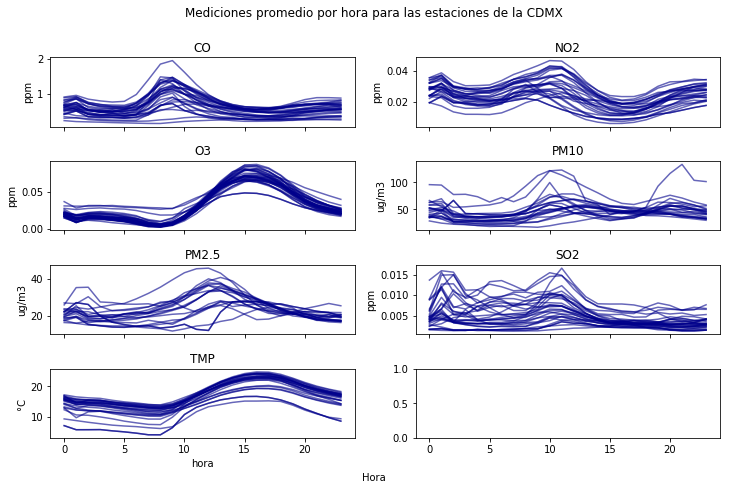

In [11]:
# Gráficas de promedio por hora del día por parámetro para cada estación de una ciudad
fig, ax = plt.subplots(4, 2, figsize=(12, 7), sharex=True)
names_unidades = {'CO':'ppm', 'NO2':'ppm', 'TMP':'°C', 'PM10':'ug/m3', 'PM2.5':'ug/m3', 'SO2':'ppm', 'O3':'ppm'}

count = 0
for parametro, df_mediciones in mediciones[mediciones.city=='Valle de México'].groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    aux.groupby('estacionesid').apply(
        lambda x: x.groupby('hora').valororig.mean().sort_index().plot(alpha=0.6, color='darkblue',
                                                                       title=parametro, ax=ax.flatten()[count])
    )
    ax.flatten()[count].set_ylabel(names_unidades[parametro])
    count+=1

fig.text(0.5, 0.04, 'Hora', ha='center')
plt.suptitle('Mediciones promedio por hora para las estaciones de la CDMX')
plt.subplots_adjust(hspace=0.5)

In [12]:
aux.groupby('estacionesid').valororig.mean().reset_index().merge(estaciones, on='estacionesid')

NameError: name 'estaciones' is not defined

In [ ]:
# Gráficas por día, promediando todas las estaciones de una ciudad por parámetro
for parametro, df_mediciones in mediciones[mediciones.city=='Valle de México'].groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    aux.sort_values('fecha', inplace=True)
    fig = aux.groupby('fecha').valororig.mean().plot(alpha=0.6, color='darkblue',
                                                                  title=parametro, figsize=(12, 6))
    plt.show()

In [ ]:
# Gráficas por día para el ozono, promediando todas las estaciones de una ciudad por parámetro
ozono_df = mediciones[mediciones.parametro=='O3']

fig, ax = plt.subplots()

for c, df_mediciones in ozono_df[ozono_df.city.isin(['Valle de México', 'Guadalajara', 'Toluca',
                                                             'Monterrey'])].groupby('city'):
    aux = filtra_mediciones(df_mediciones, 'O3')
    aux['fecha'] = pd.to_datetime(aux.fecha)
    aux.sort_values('fecha', inplace=True)

    print(aux.estacionesid.nunique())
    aux.groupby('fecha').valororig.mean().plot(alpha=0.6, figsize=(18, 8), ax=ax,
                                               label=c, legend=True)

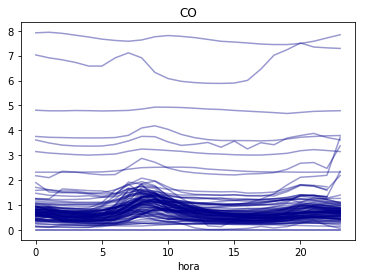

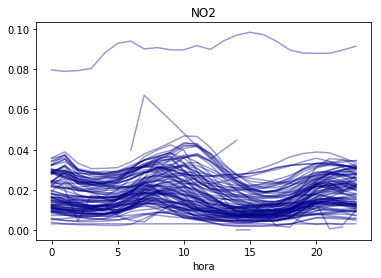

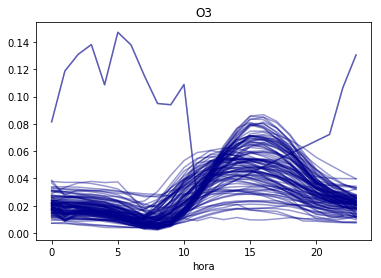

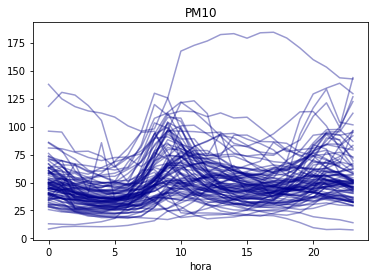

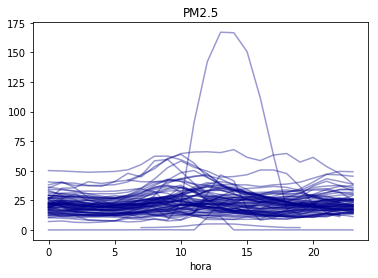

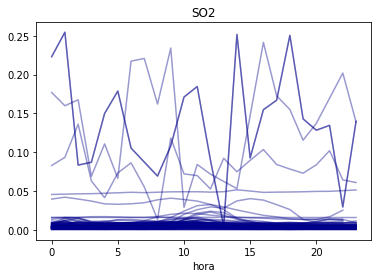

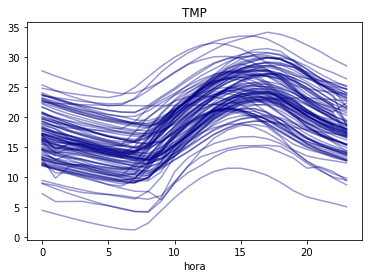

In [13]:
# Gráficas de promedio por hora del día por parámetro para cada estación
for parametro, df_mediciones in mediciones.groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    fig = aux.groupby('estacionesid').apply(
        lambda x: x.groupby('hora').valororig.mean().sort_index().plot(alpha=0.4, color='darkblue',
                                                                       title=parametro)
    )
    plt.show()

Hipótesis: El volumen de NO2 ~4 horas antes es buen predictor de la cantidad de O3.

R: Parece que no.

In [48]:
mediciones_estacion = mediciones[mediciones.estacionesid==259]
mediciones_estacion = [filtra_mediciones(df, i) for i, df in mediciones_estacion.groupby('parametro')]
mediciones_estacion = pd.concat(mediciones_estacion)

mediciones_estacion['fecha_hora']  = pd.to_datetime(mediciones_estacion.fecha + ' ' +
                                            mediciones_estacion.hora.astype(str) +':00:00')
mediciones_estacion.sort_values('fecha_hora', inplace=True)
print(mediciones_estacion.shape)
mediciones_estacion.head()

(28924, 9)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora
2271584,Valle de México,259,2018-01-01,0,O3,Ciudad de México,1,0.017,2018-01-01
1502446,Valle de México,259,2018-01-01,0,NO2,Ciudad de México,1,0.040,2018-01-01
2276384,Valle de México,259,2018-01-01,0,SO2,Ciudad de México,1,0.009,2018-01-01
2262392,Valle de México,259,2018-01-01,0,CO,Ciudad de México,1,1.100,2018-01-01
2267246,Valle de México,259,2018-01-01,0,NO2,Ciudad de México,1,0.040,2018-01-01


In [50]:
pivot_mediciones = mediciones_estacion[mediciones_estacion.parametro.isin(['NO2', 'O3', 'TMP'])]

pivot_mediciones = pivot_mediciones.pivot_table('valororig', 'fecha_hora', 'parametro')

pivot_mediciones['shift_NO2'] = pivot_mediciones.NO2.shift(5)

pivot_mediciones = pivot_mediciones.apply(lambda x: (x-x.mean())/x.std())
# pivot_mediciones = pivot_mediciones.apply(lambda x: (x-x.min())/(x.max()-x.min()))
pivot_mediciones.head(10)

parametro,NO2,O3,TMP,shift_NO2
fecha_hora,,,,
2018-01-01 00:00:00,1.432791,-0.748013,NaN,NaN
2018-01-01 01:00:00,0.738211,-0.682308,-0.998593,NaN
2018-01-01 02:00:00,0.130454,-0.550898,-1.020841,NaN
2018-01-01 03:00:00,-0.390481,-0.419489,-1.043088,NaN
2018-01-01 04:00:00,-0.737771,-0.320931,-1.154328,NaN
2018-01-01 05:00:00,-0.390481,-0.583751,-1.399056,1.432985
2018-01-01 06:00:00,-0.390481,-0.715161,-1.688279,0.738646
2018-01-01 07:00:00,-0.043191,-0.879423,-1.821767,0.131100
2018-01-01 08:00:00,0.390921,-1.109390,-1.866263,-0.389654


In [51]:
pivot_mediciones.corr()

parametro,NO2,O3,TMP,shift_NO2
parametro,,,,
NO2,1.000000,-0.278353,-0.283677,0.092421
O3,-0.278353,1.000000,0.794505,0.260503
TMP,-0.283677,0.794505,1.000000,0.043269
shift_NO2,0.092421,0.260503,0.043269,1.000000


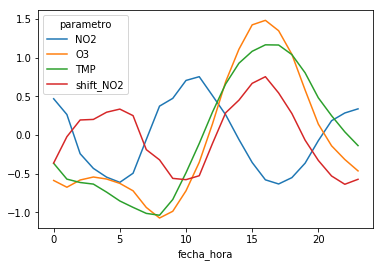

In [52]:
pivot_mediciones.groupby(pivot_mediciones.index.hour).mean().plot()

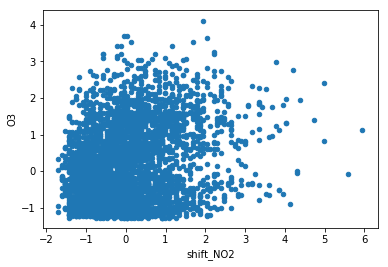

In [54]:
pivot_mediciones.plot.scatter(x='shift_NO2', y='O3')

## Contingencias Ozono CDMX vs Guadalajara

In [15]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [16]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


In [17]:
medicion_ozono = mediciones[(mediciones.city.isin(['Valle de México', 'Guadalajara'])) &
                            (mediciones.estacionesid.isin(filtered_medicion.estacionesid)) &
                            (mediciones.parametro=='O3')]
medicion_ozono['fecha'] = pd.to_datetime(medicion_ozono.fecha)

medicion_ozono['fecha_hora'] = medicion_ozono.fecha.astype(str) + medicion_ozono.hora.map(lambda x: 
                                                                                          ' %02i:00:00' %x)
medicion_ozono['fecha_hora'] = pd.to_datetime(medicion_ozono.fecha_hora)

ozono_maximo = medicion_ozono.groupby(['city', 'fecha']).valororig.max().reset_index()
# ver http://sinaica.inecc.gob.mx/pags/noms.php
ozono_maximo['mala_calidad'] = 0.096
ozono_maximo['muy_mala_calidad'] = 0.155
# Ver https://www.sedema.cdmx.gob.mx/storage/app/media/Suplemento_aire_web_.pdf
ozono_maximo['contingencia'] = .165

ozono_maximo.head()

,city,fecha,valororig,mala_calidad,muy_mala_calidad,contingencia
0,Guadalajara,2018-01-01,0.084752,0.096,0.155,0.165
1,Guadalajara,2018-01-02,0.077231,0.096,0.155,0.165
2,Guadalajara,2018-01-03,0.085322,0.096,0.155,0.165
3,Guadalajara,2018-01-04,0.105960,0.096,0.155,0.165
4,Guadalajara,2018-01-05,0.075177,0.096,0.155,0.165


Guadalajara
79 247
Valle de México
158 244


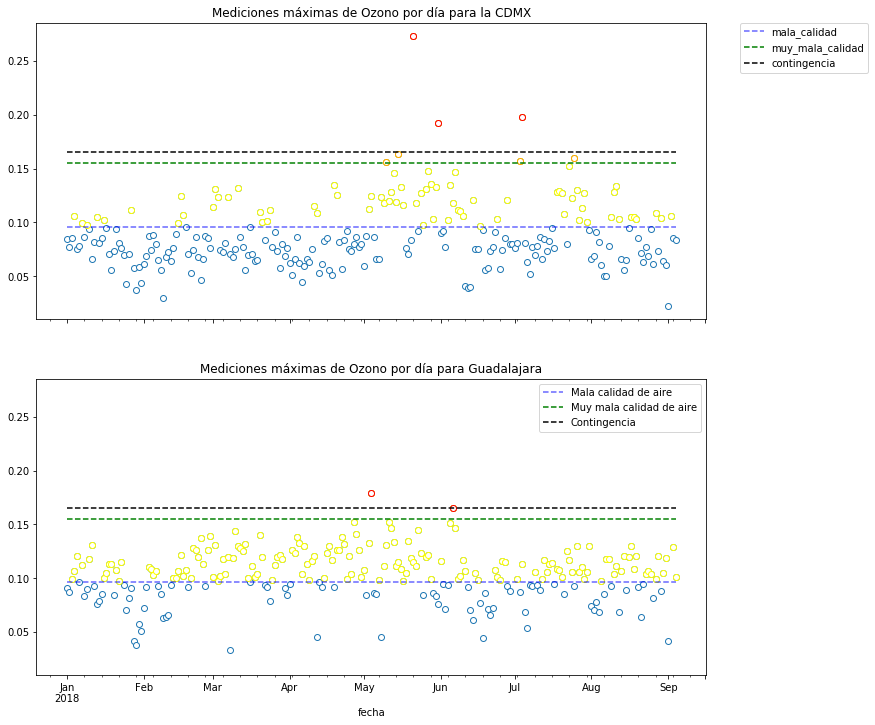

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 12))

count = 0
for i, g in ozono_maximo.groupby('city'):
    
    g['mayor_mala_calidad'] = np.where(g.valororig>g.mala_calidad,
                                          g.valororig, np.NaN)

    g['mayor_muy_mala_calidad'] = np.where(g.valororig>g.muy_mala_calidad,
                                                      g.valororig, np.NaN)

    g['mayor_contingencia'] = np.where(g.valororig>=g.contingencia,
                                                      g.valororig, np.NaN)

    g = g.set_index('fecha')
    
    aux_ax = ax.flatten()[count]

    g.valororig.plot(style='o', legend=False, **{'mfc':'white'}, ax=aux_ax)

    g.mayor_mala_calidad.plot(c='yellow', style='o', **{'mfc':'white'}, ax=aux_ax)
    g.mayor_muy_mala_calidad.plot(c='orange', style='o', **{'mfc':'white'}, ax=aux_ax)
    g.mayor_contingencia.plot(c='red', style='o', **{'mfc':'white'}, ax=aux_ax)
    
    
    if count==1:
        g.mala_calidad.plot(legend=True, label='Mala calidad de aire', style='--', c='b', alpha=0.6, ax=aux_ax)
        g.muy_mala_calidad.plot(legend=True, label='Muy mala calidad de aire', style='--', c='green', ax=aux_ax)
        g.contingencia.plot(legend=True, label='Contingencia', style='--', c='k', ax=aux_ax)
        aux_ax.set_title('Mediciones máximas de Ozono por día para Guadalajara')
        
    else:
        g.mala_calidad.plot(legend=False, style='--', c='b', alpha=0.6, ax=aux_ax)
        g.muy_mala_calidad.plot(legend=False, style='--', c='green', ax=aux_ax)
        g.contingencia.plot(legend=False, style='--', c='k', ax=aux_ax)
        aux_ax.set_title('Mediciones máximas de Ozono por día para la CDMX')
        handles, labels = aux_ax.get_legend_handles_labels()
        aux_ax.legend(handles[4::], labels[4::], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    # puntos entre la franja axul y negra
    mask = (g.mayor_mala_calidad.notnull()) & (g.mayor_contingencia.isnull()) | (g.mayor_muy_mala_calidad.notnull())
    print(i)
    print(len(g[mask]), len(g))
    
    
    count+=1
    

In [117]:
0.22111666666666663/0.172

1.2855620155038758

In [108]:
aux = medicion_ozono[(medicion_ozono.valororig>=0.165) &
                     (medicion_ozono.city=='Valle de México')].sort_values('fecha')
aux

,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora
2106298,Valle de México,251,2018-05-04,16,O3,Ciudad de México,1,0.179,2018-05-04 16:00:00
2135714,Valle de México,252,2018-05-04,16,O3,Ciudad de México,1,0.169,2018-05-04 16:00:00
2274706,Valle de México,259,2018-06-06,16,O3,Ciudad de México,1,0.165,2018-06-06 16:00:00


In [109]:
aux = medicion_ozono[(medicion_ozono.valororig>=0.165) &
                     (medicion_ozono.city=='Guadalajara')].sort_values('fecha')
aux

,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora
921953,Guadalajara,107,2018-05-21,12,O3,Jalisco,1,0.19071,2018-05-21 12:00:00
921954,Guadalajara,107,2018-05-21,13,O3,Jalisco,1,0.27285,2018-05-21 13:00:00
1018898,Guadalajara,110,2018-05-21,15,O3,Jalisco,1,0.17914,2018-05-21 15:00:00
1019138,Guadalajara,110,2018-05-31,15,O3,Jalisco,1,0.19240,2018-05-31 15:00:00
1019139,Guadalajara,110,2018-05-31,16,O3,Jalisco,1,0.19040,2018-05-31 16:00:00
888393,Guadalajara,106,2018-07-04,14,O3,Jalisco,1,0.18462,2018-07-04 14:00:00
888394,Guadalajara,106,2018-07-04,15,O3,Jalisco,1,0.19810,2018-07-04 15:00:00
888395,Guadalajara,106,2018-07-04,16,O3,Jalisco,1,0.18404,2018-07-04 16:00:00


estacionesid
106    AxesSubplot(0.125,0.2;0.775x0.68)
107    AxesSubplot(0.125,0.2;0.775x0.68)
110    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

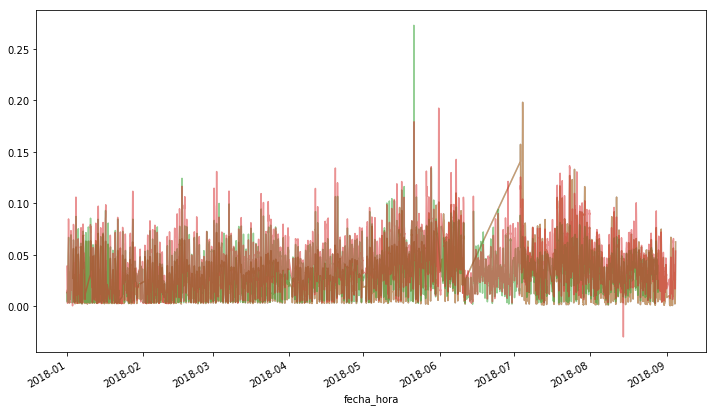

In [114]:
medicion_ozono[medicion_ozono.estacionesid.isin(aux.estacionesid)
              ].groupby('estacionesid').apply(lambda x: 
                                              x.set_index('fecha_hora').valororig.plot(figsize=(12, 7), alpha=0.5))

In [100]:
estaciones[estaciones.estacionesid.isin(aux.estacionesid)]

,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
52,5b8850e3e2705c1932e8302c,20.614444,-103.343333,106,Miravalle,MIR,63,2018-08-30 20:17:39.219
53,5b8850e3e2705c1932e8302d,20.700539,-103.296617,107,Oblatos,OBL,63,2018-08-30 20:17:39.219
56,5b8850e3e2705c1932e83030,20.680193,-103.398551,110,Vallarta,VAL,63,2018-08-30 20:17:39.219


In [102]:
medicion_contaminante[medicion_contaminante.estacionesid.isin(aux.estacionesid)]

,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
38,106,0.028283,5057,1,20.614444,-103.343333,Miravalle,Guadalajara
39,107,0.033701,5609,1,20.700539,-103.296617,Oblatos,Guadalajara
42,110,0.040464,5726,1,20.680193,-103.398551,Vallarta,Guadalajara
